# TrIPP tutorial - Lysozyme

In the following example we will use TrIPP to monitor and analyse the p*K*<sub>a</sub> of ionisable residues during Molecular Dynamics (MD) simulations of the hen egg-white lysozyme (HEWL; PDB ID: 1AKI). The input files to run this tutorial (provided in the *data* folder) are:

* **1AKI_minstr.pdb**: energy minimised structure in PDB format (1960 atoms)
* **1AKI_md1_300ns.xtc** and **1AKI_md2_300ns.xtc**: trajectory files of two 308.5-ns replicas in xtc format (frames are sampled every 100 ps, water molecules and counterions have been removed, the system is composed of a single-chain protein with no ligand)
* **1AKI_md1_pc1.csv**: projection of 1AKI_md1_300ns.xtc onto its first principal component (PC1) - only required for Part 5

The protonation state of ionisable residues during the MD simulations was determined using PROPKA (version 3.4.0) on the initial structure (pH = 7.0).

**Running time:** running all the parts of this tutorial on a Macbook Pro (M2 Pro) using 12 cores requires about 6 minutes.

**Important note on PROPKA** 

PROPKA has some requirements on the format of the input PDB file, in particular:

1. PROPKA only recognizes specific residue names (for the standard 20 amino acids).
2. The names of the two C-terminal oxygen atoms need to be O and OXT.
3. The record type of non-protein atoms (e.g., a ligand) needs to be 'HETATM'.

TrIPP has a hard-coded dictionary (tripp.\_correction_dictionary_.py) that converts a list of standard residue names recognised by [MDAnalysis](https://userguide.mdanalysis.org/stable/standard_selections.html) to names compatible with PROPKA. A dictionary is also used to convert C-terminal oxygen atom names used in the GROMOS, AMBER or CHARMM force fields to the PROPKA format. 

After this conversion, TrIPP checks if residue names or C-terminal oxygen atom names that cannot be recognised by PROPKA are still present:

1. For incompatible residue names, the calculation will be stopped unless their record type is 'HETATM' 
2. For incompatible C-terminal oxygen atoms names, the calculation will be stopped.

# 0. Libraries and user-defined variables 

Let's first import the required libraries:

In [1]:
from tripp import Trajectory
from tripp.analysis import calculate_difference_to_model
from tripp.analysis import PCProjectionScreening  
from tripp._create_mda_universe_ import create_mda_universe
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import re
from itertools import combinations
from tripp._model_pka_values_ import model_pka_values
from tripp import Visualization  # PyMOL installation required, user needs to specify the path to the PyMOL executable (see Part 2)
from tripp import Clustering 

To run this tutorial on your own trajectories, you will need to change the value of some user-defined variables. Please note that individual parts might have additional user-defined variables. 

**Chain ID and multi-chain systems:** it is recommended to have chain IDs assigned in your topology file. If the chain ID is undefined, TrIPP will automatically assign the value 'A' for all the atoms in the system. Some simple checks for possible inconsistencies due to the presence of multiple chains have been implemented (e.g. an error will be raised if duplicated residue IDs are found with no chain ID assigned) but they are not exhaustive.

**Formats:** while in principle MDAnalysis supports different trajectory and topology formats, we have tested our tool only on xtc files generated with GROMACS. 

**MDAnalysis warnings:** Depending on the PDB file used to define the system topology, MDAnalysis may issue warnings such as "missing element information." These warnings are not necessarily indicative of an error but users are advised to review them carefully to ensure the topology is interpreted as intended.

In [2]:
# Start of user-defined variables -------------------------

topology = '1AKI_minstr.pdb'  # name of the reference PDB file used to define the topology of the system
input_dir = 'data'            # name of the folder containing the input files
traj_prefix_list = ['1AKI_md1_300ns', '1AKI_md2_300ns'] # list of input trajectories (without the extension)
traj_format = 'xtc'           # extension of trajectory input files (only xtc files have been tested)
output_dir = 'output'         # name of the folder where all output files and folders will be saved

# End of user-defined variables -------------------------

ntraj = len(traj_prefix_list)
topology_file = input_dir + '/' + topology
trajectory_files = [input_dir + '/' + x + '.' + traj_format for x in traj_prefix_list]

pka_files = [output_dir + '/' + x + '/' + x + '_pka.csv' for x in traj_prefix_list]
buriedness_files = [output_dir + '/' + x + '/' + x + '_buriedness.csv' for x in traj_prefix_list]
trajectory_dict = {x: input_dir + '/' + x + '.' + traj_format for x in traj_prefix_list}

output_directories = [output_dir + '/' + x for x in traj_prefix_list]
output_prefix = traj_prefix_list

In the next sections, you will learn how to:
1. Predict the p*K*<sub>a</sub> of ionisable residues for the entire trajectory and analyse their distributions.
2. Colour the ionisable residues by their p*K*<sub>a</sub> values in a 3D representation of the protein. A PyMOL installation is required.
3. Cluster the trajectory frames on the basis of the p*K*<sub>a</sub> values of selected residues and retrieve cluster representatives.
4. Perform pseudo-mutations of selected residues to assess their contribution to the p*K*<sub>a</sub> of ionisable residues nearby.
5. Detect correlations between pKa changes and collective motions.

# 1. Trajectory p*K*<sub>a</sub> prediction

`Trajectory` is the main class provided by TrIPP and it can be used to automatically run PROPKA predictions on all the frames of the input trajectory. The calculation is sped up by slicing the trajectory into different parts, which are processed in parallel. The p*K*<sub>a</sub> and (only if requested) buried ratio ('buriedness') values of each ionizable residue are saved to individual CSV files.

In the cell below, the `Trajectory` class is used to track the predicted p*K*<sub>a</sub> values of HEWL ionisable residues in two MD trajectories. **The running time on a Macbook Pro (M2 Pro) using 12 cores is ~ 1 minute**. A successful run of this cell will produce the following files:

* **output/1AKI_md1_300ns/1AKI_md1_300ns.log**: log file with a summary of the settings, trajectory splits, run time and some statstics (Mean, Median and Standard Deviation of p*K*</sub>a</sub> values for each ionisable residue)
* **output/1AKI_md1_300ns/1AKI_md1_300ns_pka.csv**: csv file with the time (ps) in the first column + pka values for the ionisable residues calculated during the trajectory (1 column for each residue) 
* **output/1AKI_md1_300ns/1AKI_md1_300ns_buriedness.csv**: csv file with the time (ps) in the first column + buried ratio values for the ionisable residues calculated during the trajectory (1 column for each residue)
* **output/1AKI_md1_300ns/1AKI_md1_300ns_propka_warnings.log**: when present, PROPKA warnings are redirected to a separate log file

plus equivalent folders and files for the second trajectory (1AKI_md2_300ns.xtc).

**Note on 'Missing atoms' warning from PROPKA**: occasionally PROPKA might give a warning about "Missing atoms or failed protonation for XXX -- please check the structure", where XXX is an acidic or basic group of a residue as recognised by PROPKA. This is related to the use of PROPKA of pre-defined interaction atoms for these groups: https://propka.readthedocs.io/en/latest/_modules/propka/group.html. 

In [ ]:
for idx in range(ntraj):
    print(f'Processing {trajectory_files[idx]}')
    TrIPP_Traj = Trajectory(topology_file = topology_file,
                            trajectory_file = trajectory_files[idx],
                            output_directory = output_directories[idx],
                            output_prefix = output_prefix[idx],
                            hetatm_resname = None, # str or list of str of PDB residue names for non-protein molecules 
                                                   # that we want to be taken into account by PROPKA in the pKa calculation.
                                                   # Their record type will be set to 'HETATM'. e.g.: 'ADP' or ['ADP','PI2']
                            custom_terminal_oxygens = None,  # names of terminal oxygen atoms when different from ['O', 'OXT'], 
                                                             # provided as a list, e.g.: ['OC1', 'OC2']
                            custom_resname_correction = None,   # dictionary of custom protein residue names not included in
                                                                # the hard-coded TrIPP dictionary (tripp._correction_dictionary_.py). 
                                                                # Can be given as e.g. {'XXX':'ASP'}, where 'XXX' is the residue
                                                                # name in the PDB file and 'ASP' is the corresponding
                                                                # PROPKA name.
                            cpu_core_number = -1)   # number of CPU cores. Set to -1 to use all available cores.
    
    TrIPP_Traj.run(extract_buriedness_data = True,   # Set to True to save also the buriedness values, 
                                                     # otherwise only pKa values are saved.
                   mutation_selections = None,   # Set to None to run PROPKA on the original residues (no pseudo-mutations).
                                                 # See Section 4 to run pseudo-mutations.
                   save_disulphide_pka = False,   # If set to False, pka and buried ratio values for cysteines 
                                                  # forming a disulphide bond will not be saved in the CSV files. ***IM mod***
                   optargs = [])  # optargs for PROPKA.run.single(). Example of usage can be found at
                                  # https://propka.readthedocs.io/en/latest/_modules/propka/run.html#single
                                  # and the accepted flags can be found at https://propka.readthedocs.io/en/latest/command.html
                                  # Note: use ['-k'] to keep protons in input file (default: False).
    print('---------------------------------------------------------------------------------')

Processing data/1AKI_md1_300ns.xtc
---------------------------------------------------------------------------------
Processing data/1AKI_md2_300ns.xtc
---------------------------------------------------------------------------------


The distribution of the p*K*<sub>a</sub> values for each ionisable residue can be visualized by running the following cell. Heatmaps of the distributions are shown with a colour gradient (blue), while a dotted red line indicates the model p*K*<sub>a</sub> value for each residue type obtained from [PROPKA3](https://github.com/jensengroup/propka/blob/27e0ad2f8d653404f57c78f1cae2ec32cb5adb68/propka/propka.cfg#L5-L13). Note that N+ and C- correspond to the amino and carboxyl groups at the N- and C-terminus, respectively.

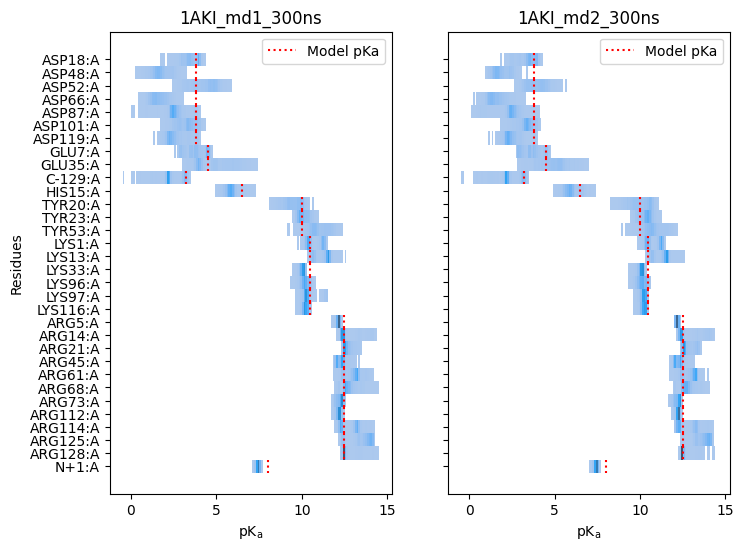

In [4]:
fig, ax = plt.subplots(1, ntraj, figsize = (4 * ntraj, 6), sharex = True, sharey = True) 
ax = np.atleast_1d(ax)

#Plot histogram showing the pKa values
for idx in range(ntraj):
    df_md = pd.read_csv(pka_files[idx]) 
    df_melt = df_md.melt(id_vars = 'Time [ps]', var_name = 'Residues', value_name = 'pKa value') 
    sns.histplot(data=df_melt, x = 'pKa value', y = 'Residues', ax = ax[idx], binwidth = 0.1)
    ax[idx].set(xlabel = r'pK$_{\rm a}$')
    ax[idx].set_title(f"{trajectory_files[idx].split('/')[-1].split('.')[0]}")
    #Adding model pKa value to each row
    for ytick, residue in enumerate([i[:3] for i in df_melt['Residues'].unique()]):
        if 'N+' in residue:
            ax[idx].vlines(model_pka_values['NTR'], ytick-0.5, ytick+0.5, colors = 'red', linestyles = 'dotted')
        elif 'C-' in residue:
            ax[idx].vlines(model_pka_values['CTR'], ytick-0.5, ytick+0.5, colors = 'red', linestyles = 'dotted')
        else:
            ax[idx].vlines(model_pka_values[residue], ytick-0.5, ytick+0.5, colors = 'red', linestyles = 'dotted')
    ax[idx].legend(['Model pKa'])
plt.show()

The acidic residues ASP52 and GLU35 are of particular interest since they show an upshift of their p*K*<sub>a</sub> values towards physiological pH, which means that an increase of their p*K*<sub>a</sub> due to the changes in the local environement would change their favoured protonation state.

TrIPP can also calculate the p*K*<sub>a</sub> deviation from the PROPKA model value for each ionisable residue and save it to a CSV file using the `calculate_difference_to_model` function. Running the cell below creates the following files:

* **output/1AKI_md1_300ns/1AKI_md1_300ns_difference_to_model.csv**: csv file with the time (ps) in the first column + p*K*<sub>a</sub> deviation from model values for the ionisable residues calculated during the 1AKI_md1_300ns.xtc trajectory (1 column for each residue)

plus an equivalent file for the second trajectory (1AKI_md2_300ns.xtc).

In [5]:
for idx in range(ntraj):
    calculate_difference_to_model(input_directory = output_directories[idx],
                                  output_prefix = output_prefix[idx])

The corresponding distributions can be visualised as above by running the following cell:

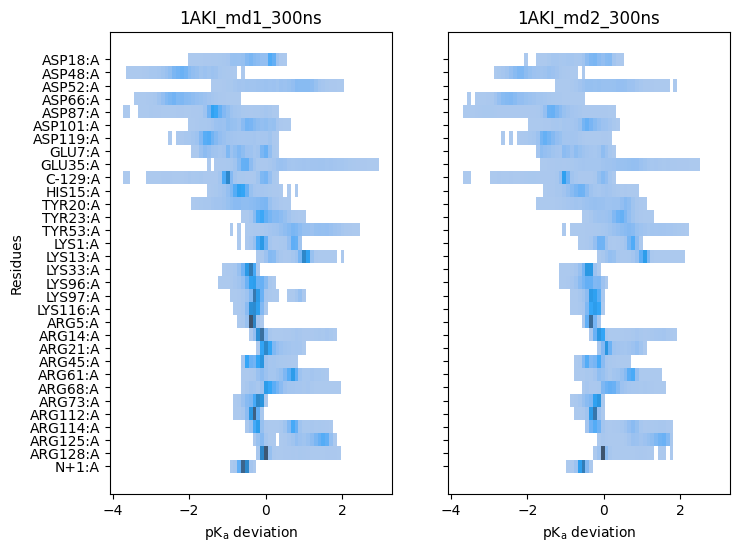

In [6]:
fig, ax = plt.subplots(1, ntraj, figsize = (4 * ntraj, 6), sharex = True, sharey = True) 
ax = np.atleast_1d(ax)

#Plot histogram showing the deviation from the model pKa values 
for idx in range(ntraj):
    df_md = pd.read_csv(f'{output_directories[idx]}/{output_prefix[idx]}_difference_to_model.csv')
    df_melt = df_md.melt(id_vars = 'Time [ps]', var_name = 'Residues', value_name = 'pKa value deviation') 
    sns.histplot(data = df_melt, x = 'pKa value deviation', y = 'Residues', ax = ax[idx], binwidth = 0.1)
    ax[idx].set(xlabel = r'pK$_{\rm a}$ deviation')
    ax[idx].set_title(f"{trajectory_files[idx].split('/')[-1].split('.')[0]}")
plt.show()

# 2. Visualizing with PyMOL

The `Visualization` class in TrIPP allows p*K*<sub>a</sub> values to be colour mapped onto a structure provided by the user. Using this class requires specifying the path to a local PyMOL exectuable in the user-defined variables section below.

There are different options for the p*K*<sub>a</sub> values to be mapped, which can be specified with the `coloring_method` argument of `gen_pse()`:

* **'mean'**: the mean p*K*<sub>a</sub> value is mapped on each ionisable residue. Mean values are calculated over all the p*K*<sub>a</sub> files specified through the `pka_file` argument of `Visualization`.

* **'difference_to_model_value'**: the difference between the mean and the model p*K*<sub>a</sub> value is mapped on each ionisable residue. Mean values are calculated over all the p*K*<sub>a</sub> files specified through the `pka_file` argument of `Visualization`.

* **'correlation'**: the coupling between p*K*<sub>a</sub> and collective motions in the protein is mapped on each ionisable residue. This option requires providing an additional file (see Part 5). 

* **an integer or float**: if the timestep of a specific frame is given, the p*K*<sub>a</sub> value calculated for that frame is mapped on each ionisable residue.

Running the cell below generates the following files:
* **output/1AKI_md_all_300ns_pka_mean.pse**: PyMOL session for the mapping of mean p*K*<sub>a</sub> values
* **output/1AKI_md_all_300ns_pka_mean.pdb**: reference PDB file with mean p*K*<sub>a</sub> values in the B-factor field
* **output/1AKI_md_all_300ns_pka_difference_to_model_value.pse**: PyMOL session for the mapping of the difference between mean and model p*K*<sub>a</sub> values
* **output/1AKI_md_all_300ns_pka_difference_to_model_value.pdb**: reference PDB file with the difference between mean and model p*K*<sub>a</sub> values in the B-factor field

In [7]:
# Start of user-defined variables -------------------------

pymol_path = '/Applications/PyMOL.app/Contents/MacOS/MacPyMOL' # path to PyMOL executable
pymol_output_prefix = '1AKI_md_all_300ns_pka' # prefix of output file names for the PyMOL analysis

# End of user-defined variables -------------------------
TrIPP_Vis = Visualization(topology_file = topology_file, 
                          pka_file = pka_files, # filename(s) (including the path), can be str or list of str
                          start = 0, # start time (as in the pKa csv file). pKa values are averaged over the frames between start and end. 
                                     # Defaults to 0 (first frame in the trajectory) 
                          end = -1)  # end time (as in the pKa csv file). pKa values are averaged over the frames between start and end.
                                     # Defaults to -1 (last frame in the trajectory).

TrIPP_Vis.gen_pse(pymol_path = pymol_path,
                  output_directory = output_dir,
                  output_prefix = pymol_output_prefix,
                  coloring_method = 'mean',  # generates PyMOL session with the mean pKa 
                  lower_limit = 0,   # Minimum of the colour scale
                  upper_limit = 14,  # Maximum of the colour scale
                  color_palette = 'red_white_blue')  # see https://pymolwiki.org/index.php/Spectrum for available palettes

TrIPP_Vis = Visualization(topology_file = topology_file, 
                          pka_file = pka_files, # filename(s) (including the path), can be str or list of str
                          start = 0, # start time (as in the pKa csv file). pKa values are averaged over the frames between start and end. 
                                     # Defaults to 0 (first frame in the trajectory)
                          end = -1) # end time (as in the pKa csv file). pKa values are averaged over the frames between start and end.
                                     # Defaults to -1 (last frame in the trajectory).

TrIPP_Vis.gen_pse(pymol_path = pymol_path,
                  output_directory = output_dir,
                  output_prefix = pymol_output_prefix,
                  coloring_method = 'difference_to_model_value',  # generates PyMOL session with the difference between the mean and the model pKa 
                  lower_limit = -3,  # Minimum of the colour scale
                  upper_limit = 2,   # Maximum of the colour scale
                  color_palette = 'red_white_blue')  # see https://pymolwiki.org/index.php/Spectrum for available palettes

 PyMOL(TM) 3.1.4.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 12 CPU cores.  Enabled multithreaded rendering.
 PyMOL(TM) 3.1.4.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 12 CPU cores.  Enabled multithreaded rendering.


Below you can see snapshots of the mapping of mean p*K*<sub>a</sub> values (left) and of the difference between mean and model p*K*<sub>a</sub> values (right) for HEWL:

 
 
 <img src="data/Mean_pka.png" width="400"/>      <img src="data/Difference_to_model_pka.png" width="400"/>

            Mean pKa values                                 Mean pKa - model values      

# 3. Clustering with p*K*<sub>a</sub> values

It is useful to have a method to extract structures that are representative of the different environments around ionisable residues observed during the trajectory. 

The `Clustering` class in TrIPP can be used to cluster the frames using one of the following methods:

* **K-medoids** (implemented as `kmedoid` method of the `Clustering` class).
* A **greedy** method as described in Micheletti et al. PROTEINS: Structure, Function, and Genetics 40:662– 674 (2000)(implemented as `greedy`).
* **DBSCAN** (implemented as `dbscan`).
* **HDBSCAN** (implemented as `hdbscan`).

The features used to describe the frames in the clustering include:

* The p*K*<sub>a</sub> values of the residues of interest.
* (Optional) All the possible pairs of distances between charge centers in those residues (`include_distances` = True).
* (Optional) The buried ratio of the residues of interest (`include_buriedness` = True)

The frame features are preprocessed (Z-score normalisation) before clustering. It is also possible to run a PCA on the features before the clustering is performed (`dimensionality_reduction` = True). 

See the main text of the TrIPP manuscript for more details on the clustering implementation.

In [8]:
# Start of user-defined variables -------------------------

residue_clust_list = ['chainID A and resid 35', # list of residue selections (MDAnalysis selection commands) to be used in the clustering
                      'chainID A and resid 52'] 
clustering_output_prefix = '1AKI_md_all_300ns' # prefix of output files from the clustering analysis

# End of user-defined variables -------------------------

u = create_mda_universe(topology_file,None)
residue_identifier_list = []
for residue_selection in residue_clust_list:
    resname = u.select_atoms(residue_selection).residues.resnames.astype(str)
    resid = u.select_atoms(residue_selection).residues.resids.astype(str)
    chainID = u.select_atoms(residue_selection).atoms.chainIDs.astype(str)[0]
    residue_identifier_list.append(np.char.add(resname, resid)[0]+':'+ chainID)

The code in the cell below clusters frames from all the input trajectories using HDBSCAN and the p*K*<sub>a</sub> values of selected residues as features. When the `automatic` argument is set to True, an automatic searching of optimal hyperparameter values is carried out. The range of hyperparameter values being tested for HDBSCAN can be set  with `min_cluster_size_range` and `min_samples_range`. If `automatic` is set to False, the hyperparameter values (`min_cluster_size`, `min_samples`) need to be set manually.

Running the cell produces the following files:

* **output/1AKI_md_all_300ns_HDBSCAN.log**: a log file containing the clustering details.
* **output/1AKI_md_all_300ns_HDBSCAN_C0.pdb**, **1AKI_md_all_300ns_HDBSCAN_C1.pdb** and **1AKI_md_all_300ns_HDBSCAN_C2.pdb**: PDB files of the representative structures of the three clusters found in the optimal clustering run (number of output clusters = 3).
* **output/1AKI_md_all_300ns_HDBSCAN_cluster.csv**: a CSV file containing the cluster label for each frame (optimal clustering), together with the p*K*<sub>a</sub> values of the selected residues.

In [9]:
TrIPP_Clust = Clustering(topology_file = topology_file, 
                         trajectory_file = trajectory_dict,  # Dictionary where the key is the name of the trajectory, and the value is the path to that trajectory
                         pka_file = pka_files,  # List of paths to pKa files
                         buriedness_file = buriedness_files,
                         selections = residue_clust_list,  # List of residues of interest (selected with MDAnalysis selection commands)
                         output_directory = output_dir,
                         output_prefix = clustering_output_prefix, 
                         include_distances = False,  # If set to true, the feature matrix will include the euclidean distance between all the possible pairs of charge centres in the selected group of residues
                         include_buriedness = False,  # If set to true, the feature matrix will include the buriedness of the selected residues
                         dimensionality_reduction = False)  # If set to true, a principal component analysis is performed on the feature matrix before clustering. Principal components accounting for up to 90% of the total variance are retained.

TrIPP_Clust.hdbscan(automatic = True, # automatic search of optimal hyperparameter values (evaluated by Silhouette score)
                    min_cluster_size_range = (20,80,5), # range and step for min_cluster_size (used only if automatic is set to True)
                    min_samples_range = (20,80,5), # range and step for min_samples (used only if automatic is set to True) 
                    max_clusters = 20, # solutions with number of clusters > max_clusters are rejected
                    min_cluster_size = None, # int, min_cluster_size (used only if automatic is set to False)
                    min_samples = None) # int, min_samples (used only if automatic is set to False)                   

Clustering with parameters min_cluster_size=20 and min_samples=20 produces 9 clusters with an average silhouette score of -0.1515.
Clustering with parameters min_cluster_size=20 and min_samples=25 produces 5 clusters with an average silhouette score of 0.0773.
Clustering with parameters min_cluster_size=20 and min_samples=30 produces 5 clusters with an average silhouette score of 0.0732.
Clustering with parameters min_cluster_size=20 and min_samples=35 produces 5 clusters with an average silhouette score of 0.0697.
Clustering with parameters min_cluster_size=20 and min_samples=40 produces 5 clusters with an average silhouette score of 0.0659.
Clustering with parameters min_cluster_size=20 and min_samples=45 produces 5 clusters with an average silhouette score of 0.0677.
Clustering with parameters min_cluster_size=20 and min_samples=50 produces 4 clusters with an average silhouette score of 0.1905.
Clustering with parameters min_cluster_size=20 and min_samples=55 produces 4 clusters wit

The frames can be plotted in the 2D space of the p*K*<sub>a</sub> pair values and coloured according to the cluster IDs from the clustering with optimal hyperparameters (outliers from the HDBSCAN clustering are labelled with a -1 cluster ID):

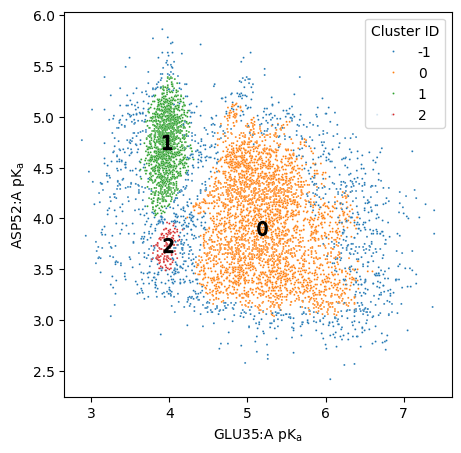

In [10]:
pairs = list(combinations(range(len(residue_identifier_list)), 2))
npairs = len(pairs)

fig, ax = plt.subplots(1, npairs, figsize = (npairs * 5, 5))
ax = np.atleast_1d(ax)

for i, idx in enumerate(pairs):
    df_cluster = pd.read_csv(f'{output_dir}/{clustering_output_prefix}_HDBSCAN_cluster.csv')
    xlabel = residue_identifier_list[idx[0]] 
    ylabel = residue_identifier_list[idx[1]]
    
    sns.scatterplot(data = df_cluster, x = xlabel, y = ylabel, s = 2, hue = 'Clusters', palette = 'tab10', ax = ax[i])
    ax[i].set(xlabel = xlabel + r' pK$_{\rm a}$')
    ax[i].set(ylabel = ylabel + r' pK$_{\rm a}$')
    ax[i].legend(title = 'Cluster ID')
    for cluster_label, cluster_idx in enumerate(TrIPP_Clust._cluster_center_indices):
        cluster_x = df_cluster.iloc[cluster_idx][xlabel]
        cluster_y = df_cluster.iloc[cluster_idx][ylabel]
        ax[i].scatter(cluster_x, cluster_y, marker=f'${cluster_label}$',c='black',s=100)
plt.show()

Looking at the structures of cluster representatives (centroids) saved in the PDB files helps explaining the pKa differences between the \*\*IM mod\*\* three \*\*IM mod\*\* clusters.
ASP52 forms a hydrogen bond with ASN44 in cluster 0 and 2, but not in cluster 1, which explains why ASP52 p*K*<sub>a</sub> tends to be lower in clusters 0 and 2 (orange and red in the plot, respectively) compared to cluster 1 (green).

There is a clear difference in the p*K*<sub>a</sub> of GLU35 between cluster 0 on one side and clusters 1 and 2 on the other. This is explained by GLU35 forming a hydrogen bond with ARG114 in clusters 1 and 2, which leads to a decrease of GLU35 p*K*<sub>a</sub> compared to cluster 0. The formation of this hydrogen bond is favoured by a conformational change of the backbone region around GLU35, which is stabilised by hydrogen bond interactions between ASN44 and the backbone of GLU35 (cluster 1). The competition between the ASP52-ASN44 and GLU35-ASN44 interactions explains the anti-correlation between GLU35 and ASP52 p*K*<sub>a</sub> values during the MD trajectories.

 <img src = "data/HDBSCAN_C0.png" width = "400"/>      <img src = "data/HDBSCAN_C1.png" width = "400"/>      <img src = "data/HDBSCAN_C2.png" width = "400"/>

# 4. _Pseudomutations_ in TrIPP 

When running TrIPP, a `mutation_selections` argument (based on MDAnalysis selection commands) can be used to mutate a given residue to alanine before the p*K*<sub>a</sub> calculations are carried out. Comparing these values with the ones from the original frames ('wild type'), provides a direct measure of the contribution of the mutated side chain to the p*K*<sub>a</sub> of the ionisable residues nearby. We called these mutations _pseudomutations_ since for each frame, only the selected residue is changed, while the rest of the protein is left unchanged (no new MD simulations are run to model how the structure of the protein changes as a result of the mutation).

In the following example, we run a total of four _pseudomutations_ (one at a time) on the two trajectories: 
- ASN44ALA
- ASN46ALA
- ASN59ALA
- ARG114ALA

Let's first select the residues to be mutated:

In [11]:
# Start of user-defined variables -------------------------

mutation_selections_list = ['chainID A and resid 44', # list of residues to be mutated (MDAnalysis selection commands)
                            'chainID A and resid 46',
                            'chainID A and resid 59',
                            'chainID A and resid 114']

residue_selections_list = ['chainID A and resid 52', 'chainID A and resid 35'] # the pKa of these residues will be plotted 
                                                                               # before ('Wild Type') and after the pseudomutation 
                                                                               # is applied (MDAnalysis selections commands)
# End of user-defined variables -------------------------

u = create_mda_universe(topology_file, None)

mutation_list = []
for mutation_selection in mutation_selections_list:
    resname = u.select_atoms(mutation_selection).residues.resnames.astype(str)
    resid = u.select_atoms(mutation_selection).residues.resids.astype(str)
    mutation_list.append(np.char.add(np.char.add(resname, resid), 'ALA')[0])

residue_identifier_list = []
for residue_selection in residue_selections_list:
    resname = u.select_atoms(residue_selection).residues.resnames.astype(str)
    resid = u.select_atoms(residue_selection).residues.resids.astype(str)
    chainID = u.select_atoms(residue_selection).atoms.chainIDs.astype(str)[0]
    residue_identifier_list.append(np.char.add(resname, resid)[0]+':'+ chainID)

mutation_output_directories = [ [output_dir + '/' + x + '_' + y for y in mutation_list] for x in traj_prefix_list ]
mutation_output_prefix = [ [ x + '_' + y for y in mutation_list] for x in traj_prefix_list ]

**The running time of the following cell on a Macbook Pro (M2 Pro) using 12 cores is ~ 5 minutes.**

Running the cell produces as many new folders in the `output_dir` as the number of _pseudomutations_, each containing a log and a pka file (see Part 1 for a description of their format).

In [12]:
for idx in range(len(trajectory_files)):
    for mtype_idx, mutation in enumerate(mutation_list): 
        print(f'Processing pseudomutation {mutation} in {trajectory_files[idx]}.')
        
        TrIPP_Traj = Trajectory(trajectory_file = trajectory_files[idx], 
                                topology_file = topology_file,
                                output_directory = mutation_output_directories[idx][mtype_idx],
                                output_prefix = mutation_output_prefix[idx][mtype_idx],
                                cpu_core_number = -1) 
        
        TrIPP_Traj.run(extract_buriedness_data = False,
                        mutation_selections = mutation_selections_list[mtype_idx],  # this can be a single or multiple mutations. 
                                                                                    # In the case of multiple mutations, provide the residues 
                                                                                    # in MDAnalysis selection commands. e.g.: 'chainID A and resid 44 46'
                        save_disulphide_pka = False,  #***IM mod*** changed to save_disulphide_pka througout.
                        optargs = [])
        print('---------------------------------------------------------------------------------')

Processing pseudomutation ASN44ALA in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation ASN46ALA in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation ASN59ALA in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation ARG114ALA in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation ASN44ALA in data/1AKI_md2_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation ASN46ALA in data/1AKI_md2_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation ASN59ALA in data/1AKI_md2_300ns.xtc.
------------------------------------------------------------------

After the calculation is complete, the p*K*<sub>a</sub> distributions of the residues listed in `residue_selections_list` are plotted to compare their values in the wild type and in the pseudomutated trajectories:

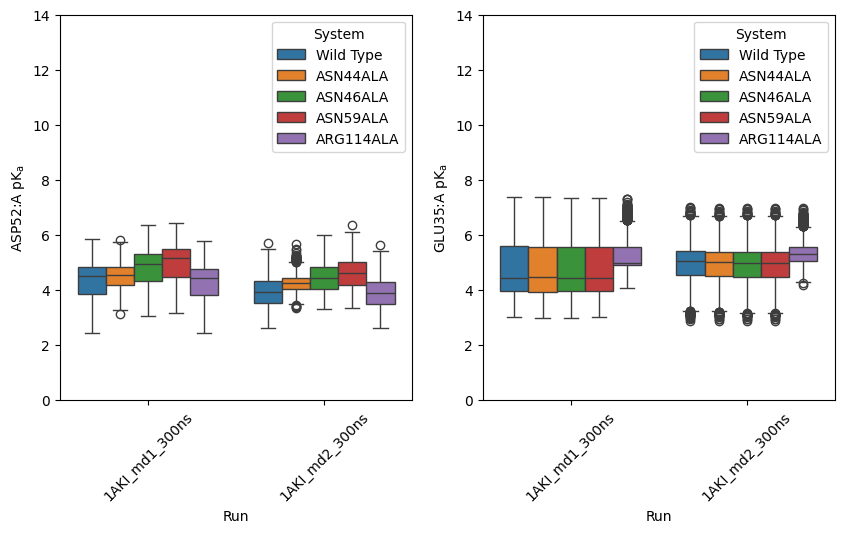

In [13]:
combined_df = []
for idx in range(len(trajectory_files)):
    pka_file = pka_files[idx]
    df = pd.read_csv(pka_file)
    df = df[['Time [ps]'] + residue_identifier_list]
    df['Run'] = f"{trajectory_files[idx].split('/')[-1].split('.')[0]}"
    df['System'] = 'Wild Type'
    combined_df.append(df)
    for mtype_idx, mutation_label in enumerate(mutation_list):
        mutation_pka_file = mutation_output_directories[idx][mtype_idx] + '/' + mutation_output_prefix[idx][mtype_idx] + '_pka.csv'
        df = pd.read_csv(mutation_pka_file)
        df = df[['Time [ps]'] + residue_identifier_list]
        df['Run'] = f"{trajectory_files[idx].split('/')[-1].split('.')[0]}"
        df['System'] = mutation_label
        combined_df.append(df)
combined_df = pd.concat(combined_df)

fig, ax = plt.subplots(1, len(residue_identifier_list), figsize = (len(residue_identifier_list) * 5,5))
ax = np.atleast_1d(ax)
for index, residue in enumerate(residue_identifier_list): 
    sns.boxplot(data = combined_df, x = 'Run', y = residue, hue = 'System', ax = ax[index]) 
    ax[index].set_ylabel(residue + r' pK$_{\rm a}$')
    ax[index].set_ylim([0, 14])
    ax[index].legend(title = 'System')
    for label in ax[index].get_xticklabels():
        label.set_rotation(45)
plt.show()

The previous cell generates two sets of boxplots. The boxplots on the left show that for both trajectories, the p*K*<sub>a</sub> distribution of ASP52 is affected by _pseudomutation_ of the three asparagines but not of the arginine residue. _Pseudomutation_ of ASN44 seems to have a slightly reduced impact compared to the other ASN residues, which can be explained by the observation that this residue does not always form interactions with ASP52 (as also shown by the cluster analysis in Part 3). The p*K*<sub>a</sub> distribution of GLU35 (boxplots on the right) is only affected by ARG114, as expected since GLU35 interacts directly with ARG114 but not with the ASN residues.

# 5. Coupling between p*K*<sub>a</sub> changes and collective motions

Calculating the correlation between p*K*<sub>a</sub> values and geometric variables describing the collective motions of the protein might be useful to identify residues whose p*K*<sub>a</sub> changes are somehow coupled with global conformational changes. Here we use the trajectory projection on a Principal Component (PC1 from a Principal Component Analysis (PCA) carried out on Cα \*\*\*IM mod\*\*\* coordinates in **1AKI_md1_300ns.xtc**), but in principle other variables could be used.

The following cell calculates the correlation coefficient between the p*K*<sub>a</sub> values of each ionisable residue in the file **1AKI_md1_300ns_pka.csv** (generated in Part 1) and the PC1 projection values in the file **1AKI_md1_300ns_pc1.csv**. 

Requirements for the file containing the projection (or other property) values:

* The file needs to be provided by the user as it is not generated in any part of this tutorial.
* It needs to be located in the `input_dir` folder defined in Part 0.
* It should contain the timestamp (first column) and the projection value (second column), seperated by a comma, for **the same frames (in the same order)** as in the input trajectory for the calculation of the p*K*<sub>a</sub>. ***IM mod ***
* It should **not** contain any header. 

Running the following cells generates the following file:

* **output/1AKI_md1_300ns/1AKI_md1_300ns_pc1_1AKI_md1_300ns_pka_correlation.csv**

In [14]:
# Start of user-defined variables -------------------------

PC_pka_pairs = {
    '1AKI_md1_300ns_pc1.csv':'1AKI_md1_300ns_pka.csv',
    } # Dictionary of PC projections, pKa file pairs: correlation coefficients will be calculated
      # between PC and pKa values in each pair of files. The files with the PC projection values need to be 
      # generated separately and moved to the `input_dir` folder defined in Part 0. The files with 
      # the pKa values have been generated in Part 1 and are stored in the `output_dir` folder, the user
      # just needs to make sure that the correct name for those files is used in this dictionary. 

# End of user-defined variables -------------------------

npairs = len(PC_pka_pairs)
unrolled_PC = [x for x in PC_pka_pairs.keys()]
unrolled_pka = [x for x in PC_pka_pairs.values()]

output_prefix_list = [unrolled_PC[i].split('.')[0] + '_' + unrolled_pka[i].split('.')[0] for i in range(npairs)]

In [15]:
for idx in range(npairs):
    output_dir_idx = output_dir + "/" + re.search(r"(.+)_pka", unrolled_pka[idx]).group(1)
    PCProjectionScreening(output_directory = output_dir_idx,
                          output_prefix = output_prefix_list[idx] + '_correlation',
                          pka_file = output_dir_idx + "/" + unrolled_pka[idx],  # Path+name of the CSV file with pKa values
                          projection_file = input_dir + "/" + unrolled_PC[idx],  # Path+name of the CSV file with PC projection values
                          method = 'Pearson', # Correlation method, can be 'Pearson' or 'Spearman'
                          start=0, # start of the timestamp for calculating correlation ***IM mod***
                          end=-1, # end of the timestamp for calculating correlation ***IM mod***
                          header=None) # use header=0 if your projection_file contains header in the first row. ***IM mod***

If a working installation of PyMOL is available, correlation values can be colour mapped onto the structure using our `Visualization` class and the `correlation_file` argument. A `correlation_threshold` argument can be also used to show only residues with correlation above/below a given value.

Running the following cell requires having defined the `pymol_path` variable in Part 2. It will generate the following files:

* **output/1AKI_md1_300ns/1AKI_md1_300ns_pc1_1AKI_md1_300ns_pka_correlation.pdb**: PDB file with the reference structure and the correlation values stored in the B-factor column (ionisable residues only) 
* **output/1AKI_md1_300ns/1AKI_md1_300ns_pc1_1AKI_md1_300ns_pka_correlation.pse**: PyMOL session

In [16]:
for idx in range(npairs):
    output_dir_idx = output_dir + '/' + re.search(r'(.+)_pka', unrolled_pka[idx]).group(1)
    Corr_Vis = Visualization(topology_file = topology_file,
                             pka_file = None, # Need to be set to None to bypass the start and end parameters
                             correlation_file = output_dir_idx + '/' + output_prefix_list[idx] + '_correlation.csv')  # Path+name of the CSV file 
                                                                                                                      # with the PC vs pKa correlation 
                                                                                                                      # coefficients

    Corr_Vis.gen_pse(pymol_path = pymol_path, # path to PyMOL executable
                     output_directory = output_dir_idx,
                     output_prefix = output_prefix_list[idx],
                     coloring_method = 'correlation',  # Residues will be coloured according to the PC vs pKa correlation coefficient
                     lower_limit = -1,  # Minimum of the colour scale
                     upper_limit = 1,   # Maximum of the colour scale
                     correlation_threshold = 0.5,  # Show only residues with absolute correlation coefficient above this threshold
                     color_palette = 'red_white_blue')

 PyMOL(TM) 3.1.4.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 12 CPU cores.  Enabled multithreaded rendering.


 <img src="data/PC_projection_correlation.png" width="400"/> 

The figure above shows a structure from the PyMOL session file generated in the previous cell, which \*\*IM mod\*\* highlights \*\*IM mod\*\* a strong coupling between the dominant collective motion observed in the first trajectory and the p*K*<sub>a</sub> values of our three residues GLU35, ASP52 and ARG114.

Although this analysis is presented at the end of this tutorial, for new systems without prior knowledge of key residues, it may be useful to perform it early to identify residues whose p*K*<sub>a</sub> values could be correlated with functional motions.